# A game of flipper with MNIST

What happens if you vertically flip MNIST images at random, and then train a classifier to detect flips? You expect to obtain a high, but not perfect score. 
The character 1 may be written as a vertical bar, in which case a vertical flip cannot be detected. And isn't the character 8 more sometime symmetrical in both axis?

To find an answer to these questions, I have built a image classifier with PyTorch. Handling of image data in PyTorch is relatively straightforward. 
The quickest approach may be to store MNIST and a flipped copy of MNIST in different directories on disk. TorchVision has a data loader that reads in images that are organized in directories according to class. 

The approach that I take, is to apply random transformations to the existing MNIST dataset in TorchVision, as this offers a great opportunity to dive into the code behind the `DataSet`. Another advantage is that we can play the flipper game with other datasets with making minimal changes to the code. 


### Torch datasets
The proposed transformation flips a coin, each time a example is requested from the dataset. If the outcome is head, the image is flipped vertically and the label is overwritten with the number 1. If the outcome is tail, the image is left as is and the label is overwritten with the number 0. 

Now, the constructor of `torchvision.dataset.MNIST` accepts transformations that act either on the images or on the data. 

```python
trainset = torchvision.datasets.MNIST(root=PATH, train=True,
                                            download=True, transform=image_transforms,
                                            target_transform=target_transforms)
```

This is somewhat problematic as the transformation of the labels should be consistent with the transformation of the images. The `PinballFlip` object offers two  transformation that are consistent, by maintaining an internal state.

```python
flipper = PinballFlip(p=0.5)
```
See `flipper/transform.py` for details. 

The pinball transformations are applied together with a few more image transformations:
```python
image_transforms = transforms.Compose(
        [transforms.Resize(size=224),
         flipper.image_transform,
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
         duplicate_channels
         ])
target_transforms = flipper.target_transform
```
The image scaling and channel duplication are nothing but a practical way to use a pre-trained Resnet with minimal effort. 
I admit: it is not pretty, but it saves some time.

### Visualizing random flips
In the plots below it can be seen that labels are consistent with the random flips.

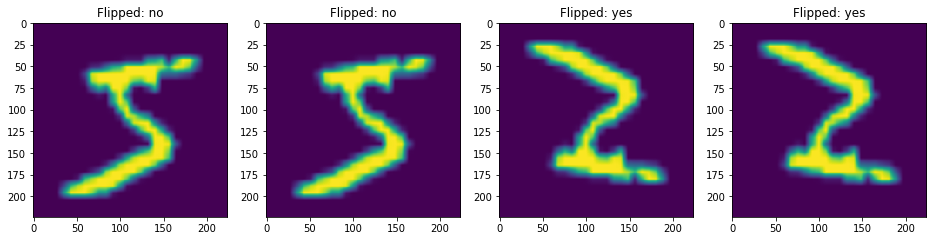

In [2]:
plot_random_flips(trainset, sample_index=0)

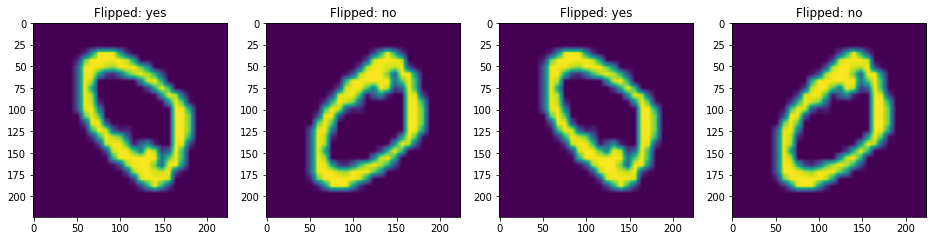

In [79]:
plot_random_flips(trainset, sample_index=1)

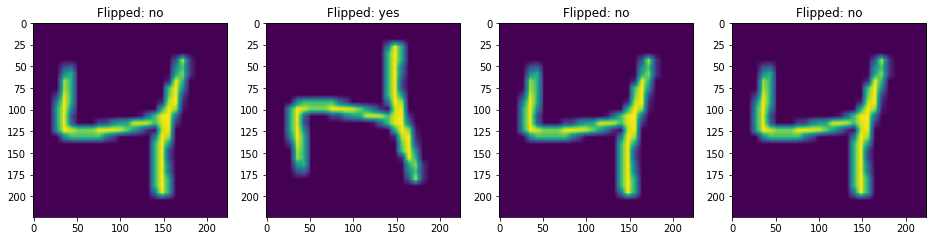

In [80]:
plot_random_flips(trainset, sample_index=2)

### Observations
Even though 0 is supposedly symmetric under flips, in practice it is often not. We see
- A clear starting point 
- Some skew
- Differences in curvature

This leads me to believe that the Bayes rate for this problem will be high (say 99%, but more images should be inspected before such a claim can be made).

### Training a model

Transfer learning is the quickest way to create a neural network classifier on simple images. Below I train the Resnet18 architecture to get a quick impression of how a classifier performs on this dataset. 

After one epoch the evaluation accuracy is 88.9 percent. This is a sign that we are on the right way. As the learning rate has not been tuned and the network was trained for one epoch only, chances are that this number goes up with a little more effort.


### Next steps
- Tuning the learning rate somewhat
- Train for a few more epochs
- Error analysis  (which example cannot be classified correctly)
- Analysis based on character (Is it true that flips in the character 1 are harder to detect?)

In [5]:
import torchvision
from torch import nn

In [6]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

NameError: name 'device' is not defined

In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5132 Acc: 0.7914
val Loss: 0.2739 Acc: 0.8891

Epoch 1/24
----------


Process Process-16:
Process Process-15:
Process Process-13:
Process Process-14:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda